# **Bacteria Prediction**

The task is to classify 10 different bacteria species using data from a genomic analysis technique that has some data compression and data loss. In this technique, 10-mer snippets of DNA are sampled and analyzed to give the histogram of base count (Raman spectroscopy). In other words, the DNA segment ATATGGCCTT becomes A2T4G2C2. We want to accurately predict bacteria species starting from this lossy information.

## **Data Loading**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global variables
random_seed = 42

In [2]:
# Print directory structure
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-feb-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2022/train.csv
/kaggle/input/tabular-playground-series-feb-2022/test.csv


In [3]:
# Load training set
df = pd.read_csv("/kaggle/input/tabular-playground-series-feb-2022/train.csv")

## **Data Analysis**

We will first analyze the dataset, in order to investigate its shape and the presence of null values.

Each row of data contains a spectrum of histograms generated by repeated measurements of a sample, each row containing the output of all 286 histogram possibilities (e.g., A0T0G0C10 to A10T0G0C0) which then has a bias spectrum (of totally random ATGC) subtracted from the results. The data (both train and test) also contains simulated measurement errors (of varying rates) for many of the samples, which makes the problem more challenging.

In [4]:
df.shape

(200000, 288)

In [5]:
df.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica
3,3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


In [6]:
df.dtypes

row_id         int64
A0T0G0C10    float64
A0T0G1C9     float64
A0T0G2C8     float64
A0T0G3C7     float64
              ...   
A9T0G0C1     float64
A9T0G1C0     float64
A9T1G0C0     float64
A10T0G0C0    float64
target        object
Length: 288, dtype: object

We are working with very high dimensional data, which can make the learning process more difficult.
It will be necessary to mitigate this problem by using a dimensionality reduction technique.

In [7]:
# We drop the row_id column because we will not use it
df.drop(columns=["row_id"], inplace=True)
df.shape

(200000, 287)

In [8]:
# Check the presence of null values
df.isnull().values.any()

False

In [9]:
# Check the absence of values equals to zero
df.all().all()

True

As we have seen, in the dataframe there aren't null or 0 values.

In [10]:
df.describe()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
count,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05
mean,6.421457e-07,-0.000003,-0.000014,-0.000010,0.000005,0.000025,0.000014,-0.000009,-0.000028,-0.000008,...,0.000135,0.000348,0.000253,0.000464,0.000581,0.000379,0.000062,8.982134e-05,1.170014e-04,2.215407e-07
std,8.654927e-05,0.000132,0.000287,0.000436,0.000683,0.000869,0.000775,0.000441,0.000107,0.000083,...,0.000711,0.001117,0.000914,0.001238,0.001528,0.001182,0.000466,5.475606e-04,6.788277e-04,2.050081e-05
min,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
25%,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
50%,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000237,-0.000199,-0.000114,-0.000043,-0.000010,...,0.000014,0.000064,0.000047,0.000124,0.000114,0.000043,-0.000010,4.632568e-07,4.632568e-07,-9.536743e-07
75%,-9.536743e-07,-0.000003,-0.000013,-0.000004,-0.000011,0.000003,-0.000030,0.000004,-0.000028,-0.000010,...,0.000111,0.000463,0.000297,0.000684,0.000774,0.000365,0.000030,6.046326e-05,6.946326e-05,-9.536743e-07
max,9.999046e-03,0.009990,0.009957,0.009886,0.019800,0.019760,0.019800,0.009886,0.009957,0.009990,...,0.019957,0.019914,0.019957,0.019914,0.019914,0.019957,0.009990,9.990463e-03,1.999046e-02,9.990463e-04


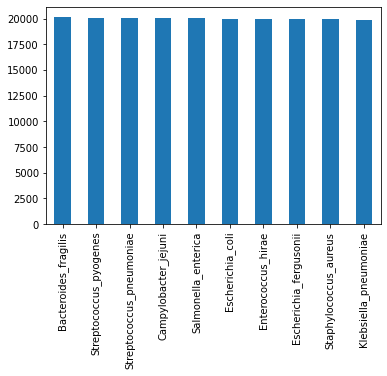

In [11]:
# Plot the distribution of values for the target column
df["target"].value_counts().plot(kind="bar");

As we can see, the 10 different classes in the dataset are balanced.

## **Target Labels Encoding**

We start the preprocessing of the dataset by encoding the labels of the target class.
For this purpose we will use the LabelEncoder provided by sklearn, which will map each textual label into a number between 0 and 9.

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
# Label encoding of the target.
# We will map each of the 10 different target classess to an intger in the range 0-9
label_encoder = LabelEncoder()
df["target"] = label_encoder.fit(df["target"]).transform(df["target"])
df.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,9
1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,6
2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,-0.000007,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,6
3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,-0.000007,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,6
4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,2


## **Train-Test Split**

Altrought Kaggle provides separate training and test set for this task, we don't have access to the full test set.
For this reason for now we will assume to have only the data in train.csv, and we will split it in two sets for training and testing.
The test set will be equal to 1/3 of the initial dataset.

In [14]:
# Imports
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=["target"]), df["target"], test_size=0.33, stratify=df["target"], random_state=random_seed)

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (134000, 286)
Y_train shape: (134000,)
X_test shape: (66000, 286)
Y_test shape: (66000,)


## **Utility Functions Definition**

Now we define some functions that we will use later in the code.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

We will use cross validation to test several models with different hyper-parameters, each time using the function **print_grid_search_results** to print the results of the search.

In [18]:
# Print grid search results.
# Input: GridSearchCV object
def print_grid_search_results(gscv):
    print("Best parameters set found on train set:")
    print(gscv.best_params_)
    print("\n")
    print("Grid scores on train set:")
    for param, mean, std in zip(gscv.cv_results_['params'], gscv.cv_results_['mean_test_score'], gscv.cv_results_['std_test_score']):
        print("%r mean: %0.3f std: +/- %0.03f)" % (param, mean, std))
    print("\n")

We will also use a simple plot function based on matplotlib.pyplot

In [19]:
# Show x-y curve plot
def show_curve(x, y, x_label, y_label, title):
    plt.figure(figsize=(10,5))
    plt.plot(x, y, '-o', linewidth=5, markersize=10)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title, fontsize = 10)
    plt.show();

Finally we have the function **build_PCA_pipeline** which will be used to construct a ML pipeline given a specific classifier to use and the number of output components of the PCA performed at beginning of the pipeline, in order to reduce the dimensions of the input data.

Each pipeline will comprehend 3 stages:
1. Standardization of the input data, by removing for each feature the mean and scaling to unit variance. (Required before doing PCA)
2. Principal Component Analysis (PCA)
3. Classification of the PCA-transformed data by a specific classifier

In [20]:
# Construct a ML pipeline with initial PCA
# Inputs:
#  - classifier to use as the last step of the pipeline
#  - number of output dimensions of the PCA transformation
def build_PCA_pipeline(classifier, pca_n_components=None):
    st_scaler = StandardScaler()
    pca = PCA(n_components=pca_n_components, random_state=random_seed)
    pipe = Pipeline(steps=[("st_scaler", st_scaler), ("pca", pca), ("classifier", classifier)])
    return pipe

## **Dimensionality Reduction** 

### **Grid Search with Cross Validation to find the best value for n_components of PCA**

We will use PCA in order to reduce the dimensionality of the data.
We will use cross validation to find the best number of output dimensions from the PCA, by testing for each possible dimension the performance of a simple decision tree classifier, which will be used as an indicator.

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [22]:
# Define the decision tree to use for testing, and construct the pipeline with it.
classifier = DecisionTreeClassifier(criterion="entropy", random_state=random_seed)
pipe = build_PCA_pipeline(classifier)

In [23]:
# The grid search will concern only the paramater n_components of the PCA module, which is the number of output dimensions of the transformed data.
param_grid = {
    "pca__n_components": [3, 5, 8, 10, 20, 50]
}

In [24]:
# Define and start the grid search using the data in the training set
grid_search = GridSearchCV(pipe, param_grid, cv=2, verbose=2)
grid_search.fit(X_train, Y_train);

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] pca__n_components=3 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. pca__n_components=3, total=   3.9s
[CV] pca__n_components=3 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] .............................. pca__n_components=3, total=   3.8s
[CV] pca__n_components=5 .............................................
[CV] .............................. pca__n_components=5, total=   4.1s
[CV] pca__n_components=5 .............................................
[CV] .............................. pca__n_components=5, total=   4.1s
[CV] pca__n_components=8 .............................................
[CV] .............................. pca__n_components=8, total=   4.7s
[CV] pca__n_components=8 .............................................
[CV] .............................. pca__n_components=8, total=   5.1s
[CV] pca__n_components=10 ............................................
[CV] ............................. pca__n_components=10, total=   5.1s
[CV] pca__n_components=10 ............................................
[CV] ............................. pca__n_components=10, total=   5.0s
[CV] pca__n_components=20 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.3min finished


In [25]:
print_grid_search_results(grid_search)

Best parameters set found on train set:
{'pca__n_components': 5}


Grid scores on train set:
{'pca__n_components': 3} mean: 0.920 std: +/- 0.000)
{'pca__n_components': 5} mean: 0.928 std: +/- 0.001)
{'pca__n_components': 8} mean: 0.923 std: +/- 0.000)
{'pca__n_components': 10} mean: 0.919 std: +/- 0.001)
{'pca__n_components': 20} mean: 0.919 std: +/- 0.000)
{'pca__n_components': 50} mean: 0.909 std: +/- 0.000)




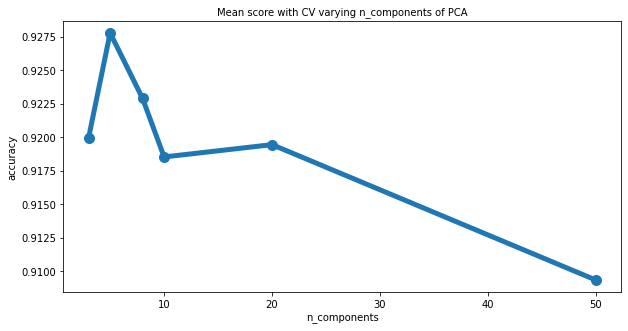

In [26]:
show_curve(param_grid["pca__n_components"],
           grid_search.cv_results_['mean_test_score'],
           "n_components",
           "accuracy",
           "Mean score with CV varying n_components of PCA")

As we can see, the best results are obtained with a number of components less than 10, which is a great dimensionality reduction considering that we started with 286 dimensions.

In [27]:
# Store the best number of components found
pca_n_components = grid_search.best_params_["pca__n_components"]

## **ML Models Testing**

Now we will test four different classificators to find the most appropriate to solve the task:
1. (Simple) Decision Tree
2. Random Forest
3. Extremely Randomized Trees
4. Deep Neural Network

For the first three non-deep models we will use cross validation in order to set their hyper-paramaters and test their performances.
The Deep Neural Network instead will be trained and tested using a more classical train-validation data split.

### **Decision Tree Classifier**

Let's start with a simple decision tree classifier.

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
# Construct the PCA-pipeline using the selected classifier
classifier = DecisionTreeClassifier(criterion="entropy", random_state=random_seed)
pipe = build_PCA_pipeline(classifier, pca_n_components)

# Define the parameter grid to use in the the grid search with cross validation.
# For the decision tree we will consider the hyper-parameter which controls the max depth of the tree.
param_grid = {
    "classifier__max_depth": [4,8,16,20,24,26]
}

# Perform the search on the training set
grid_search = GridSearchCV(pipe, param_grid, cv=2, verbose=2)
grid_search.fit(X_train, Y_train);

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] classifier__max_depth=4 .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... classifier__max_depth=4, total=   4.1s
[CV] classifier__max_depth=4 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] .......................... classifier__max_depth=4, total=   3.5s
[CV] classifier__max_depth=8 .........................................
[CV] .......................... classifier__max_depth=8, total=   3.9s
[CV] classifier__max_depth=8 .........................................
[CV] .......................... classifier__max_depth=8, total=   3.9s
[CV] classifier__max_depth=16 ........................................
[CV] ......................... classifier__max_depth=16, total=   4.1s
[CV] classifier__max_depth=16 ........................................
[CV] ......................... classifier__max_depth=16, total=   4.0s
[CV] classifier__max_depth=20 ........................................
[CV] ......................... classifier__max_depth=20, total=   4.1s
[CV] classifier__max_depth=20 ........................................
[CV] ......................... classifier__max_depth=20, total=   4.0s
[CV] classifier__max_depth=24 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   48.4s finished


In [30]:
print_grid_search_results(grid_search)

Best parameters set found on train set:
{'classifier__max_depth': 26}


Grid scores on train set:
{'classifier__max_depth': 4} mean: 0.595 std: +/- 0.012)
{'classifier__max_depth': 8} mean: 0.763 std: +/- 0.004)
{'classifier__max_depth': 16} mean: 0.899 std: +/- 0.000)
{'classifier__max_depth': 20} mean: 0.920 std: +/- 0.001)
{'classifier__max_depth': 24} mean: 0.926 std: +/- 0.001)
{'classifier__max_depth': 26} mean: 0.927 std: +/- 0.001)




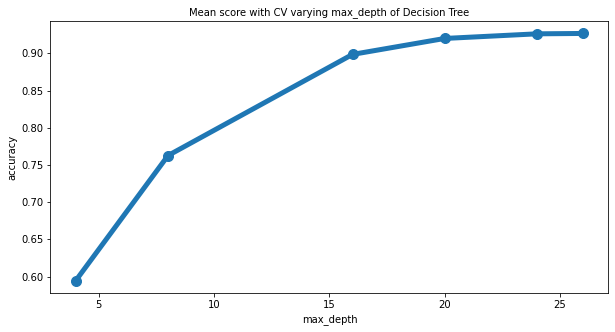

In [31]:
show_curve(param_grid["classifier__max_depth"],
           grid_search.cv_results_['mean_test_score'],
           "max_depth",
           "accuracy",
           "Mean score with CV varying max_depth of Decision Tree")

In [32]:
# Define the final model with the best parameter found
best_max_depth = grid_search.best_params_["classifier__max_depth"]
tree_model = DecisionTreeClassifier(criterion="entropy", random_state=random_seed, max_depth=best_max_depth)

## **Random Forest**

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In random forests each tree in the ensemble is built from a sample drawn with replacement from the training set.
Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features.

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
# Construct the PCA-pipeline using the selected classifier
classifier = RandomForestClassifier(criterion="entropy", random_state=random_seed)
pipe = build_PCA_pipeline(classifier, pca_n_components)

# Define the parameter grid to use in the the grid search with cross validation.
# For the random forest we will consider the hyper-parameter which controls the number of trees to use.
param_grid = {
    #"classifier__n_estimators": [5,10,20,50,100,150]
    "classifier__n_estimators": [10,150]
}

# Perform the search on the training set
grid_search = GridSearchCV(pipe, param_grid, cv=2, verbose=2)
grid_search.fit(X_train, Y_train);

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] classifier__n_estimators=10 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... classifier__n_estimators=10, total=   6.3s
[CV] classifier__n_estimators=10 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] ...................... classifier__n_estimators=10, total=   6.3s
[CV] classifier__n_estimators=150 ....................................
[CV] ..................... classifier__n_estimators=150, total=  45.9s
[CV] classifier__n_estimators=150 ....................................
[CV] ..................... classifier__n_estimators=150, total=  46.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min finished


In [35]:
print_grid_search_results(grid_search)

Best parameters set found on train set:
{'classifier__n_estimators': 150}


Grid scores on train set:
{'classifier__n_estimators': 10} mean: 0.934 std: +/- 0.001)
{'classifier__n_estimators': 150} mean: 0.940 std: +/- 0.000)




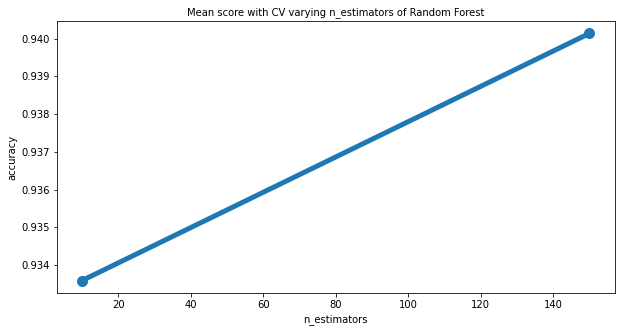

In [36]:
show_curve(param_grid["classifier__n_estimators"],
           grid_search.cv_results_['mean_test_score'],
           "n_estimators",
           "accuracy",
           "Mean score with CV varying n_estimators of Random Forest")

In [37]:
# Define the final model with the best parameter found
best_n_estimators = grid_search.best_params_["classifier__n_estimators"]
rnd_forest_model = RandomForestClassifier(criterion="entropy", n_estimators=best_n_estimators, random_state=random_seed)

### **Extremely Randomized Trees**

In extremely randomized trees, randomness goes one step further compared to random forest in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias

In [38]:
from sklearn.ensemble import ExtraTreesClassifier

In [39]:
# Construct the PCA-pipeline using the selected classifier
classifier = ExtraTreesClassifier(criterion="entropy", random_state=random_seed)
pipe = build_PCA_pipeline(classifier, pca_n_components)

# Define the parameter grid to use in the the grid search with cross validation.
# For this model we will consider the hyper-parameter which controls the number of trees to use.
param_grid = {
    #"classifier__n_estimators": [5,10,20,50,100,150]
    "classifier__n_estimators": [10,150]
}

# Perform the search on the training set
grid_search = GridSearchCV(pipe, param_grid, cv=2, verbose=2)
grid_search.fit(X_train, Y_train);

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] classifier__n_estimators=10 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... classifier__n_estimators=10, total=   3.9s
[CV] classifier__n_estimators=10 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] ...................... classifier__n_estimators=10, total=   4.0s
[CV] classifier__n_estimators=150 ....................................
[CV] ..................... classifier__n_estimators=150, total=  13.7s
[CV] classifier__n_estimators=150 ....................................
[CV] ..................... classifier__n_estimators=150, total=  13.6s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.2s finished


In [40]:
print_grid_search_results(grid_search)

Best parameters set found on train set:
{'classifier__n_estimators': 150}


Grid scores on train set:
{'classifier__n_estimators': 10} mean: 0.937 std: +/- 0.001)
{'classifier__n_estimators': 150} mean: 0.941 std: +/- 0.000)




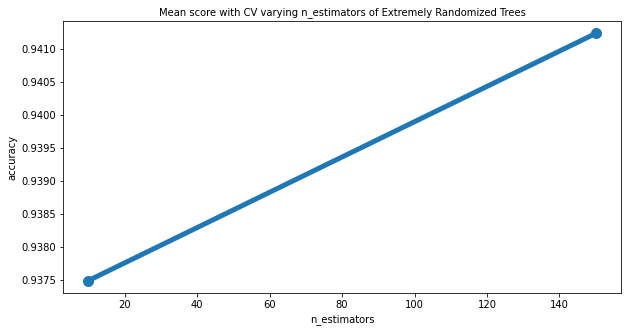

In [41]:
show_curve(param_grid["classifier__n_estimators"],
           grid_search.cv_results_['mean_test_score'],
           "n_estimators",
           "accuracy",
           "Mean score with CV varying n_estimators of Extremely Randomized Trees")

In [42]:
# Define the final model with the best parameter found
best_n_estimators = grid_search.best_params_["classifier__n_estimators"]
ext_rnd_trees_model = ExtraTreesClassifier(criterion="entropy", n_estimators=best_n_estimators, random_state=random_seed)

### **Deep Neural Network**

Now we will test a simple deep neural network architecture, using the keras library.

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [44]:
# Network architecture definition
inputs = keras.Input(shape=(pca_n_components,))
x = layers.Dense(30, activation="relu")(inputs)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

dnn_model = keras.Model(inputs=inputs, outputs=outputs, name="dnn_model")
dnn_model.summary()

Model: "dnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 30)                180       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                21

2022-03-10 16:45:20.778665: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [45]:
dnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)

This time we are not using a sklearn pipeline, so we need to compute the PCA transformation manually on the training set.
We need to split further the training set for training and validating the model, also being careful not to use the validation data to fit the PCA.

In [46]:
# Preprocess training set

# Further split the training set in training and validation sets
X_train_t, X_train_val, Y_train_t, Y_train_val = train_test_split(X_train, Y_train, test_size=0.20, stratify=Y_train, random_state=random_seed)

# Standardize the features
st_scaler_dnn = StandardScaler()
st_scaler_dnn.fit(X_train_t)
X_train_t = st_scaler_dnn.transform(X_train_t)
X_train_val = st_scaler_dnn.transform(X_train_val)

# Perform PCA
pca_dnn = PCA(n_components=pca_n_components, random_state=random_seed)
pca_dnn.fit(X_train_t)
X_train_t_pca = pca_dnn.transform(X_train_t)
X_train_val_pca = pca_dnn.transform(X_train_val)

print(f"Shape of X_train_t_pca: {X_train_t_pca.shape}")
print(f"Shape of X_train_val_pca: {X_train_val_pca.shape}")

Shape of X_train_t_pca: (107200, 5)
Shape of X_train_val_pca: (26800, 5)


In [47]:
history = dnn_model.fit(X_train_t_pca, Y_train_t, batch_size=64, epochs=5, validation_data=(X_train_val_pca, Y_train_val))

2022-03-10 16:45:26.822473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1675/1675 [==============================] - 8s 4ms/step - loss: 0.8991 - accuracy: 0.6704 - val_loss: 0.6715 - val_accuracy: 0.7460
Epoch 2/5
1675/1675 [==============================] - 6s 4ms/step - loss: 0.5870 - accuracy: 0.7871 - val_loss: 0.5250 - val_accuracy: 0.8065
Epoch 3/5
1675/1675 [==============================] - 6s 3ms/step - loss: 0.4991 - accuracy: 0.8083 - val_loss: 0.4917 - val_accuracy: 0.8009
Epoch 4/5
1675/1675 [==============================] - 6s 4ms/step - loss: 0.4623 - accuracy: 0.8163 - val_loss: 0.4625 - val_accuracy: 0.8132
Epoch 5/5
1675/1675 [==============================] - 6s 3ms/step - loss: 0.4420 - accuracy: 0.8196 - val_loss: 0.4202 - val_accuracy: 0.8294


## **Final Model Evaluation**

The previous parts were needed in order to determine the more appropriate model to solve our task.
Now we will take the model with the hightest score in the cross validation (or on the validation set in the case of deep network) and we will test in on the test set.
If the model is non-deep, it will be trained on the full training set before the testing.

In [48]:
from sklearn.metrics import classification_report

In [49]:
# After testing all the previous models, the random forest appeared to be the one with the best performance, so we will use it.

final_model = rnd_forest_model
use_neural_network = False

In [50]:
# If we are using the deep network model, it's necessary to manually do the PCA transformation:

if use_neural_network:
    # Preprocess test data
    # Standardize
    X_test = st_scaler_dnn.transform(X_test)
    # PCA
    X_test = pca_dnn.transform(X_test)

In [51]:
# Now we can use the selected model to compute the predictions.

if use_neural_network:
    # Predict probabilty distributions over possible labels
    Y_test_pred_p = final_model.predict(X_test)
    # Store the index of the most probable label
    Y_test_pred = np.argmax(Y_test_pred_p, axis=1)
else:
    # Train the full model on the complete training set
    final_pipe = build_PCA_pipeline(final_model, pca_n_components)
    final_pipe.fit(X_train, Y_train)
    # Directly predict labels
    Y_test_pred = final_pipe.predict(X_test)

In [52]:
# Print classification report on the test set
print(classification_report(Y_test, Y_test_pred, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

    Bacteroides_fragilis       0.98      0.99      0.99      6646
    Campylobacter_jejuni       0.98      0.99      0.99      6621
      Enterococcus_hirae       0.97      0.97      0.97      6583
        Escherichia_coli       0.97      0.96      0.96      6586
  Escherichia_fergusonii       0.96      0.97      0.97      6579
   Klebsiella_pneumoniae       0.99      0.99      0.99      6549
     Salmonella_enterica       0.98      0.98      0.98      6610
   Staphylococcus_aureus       0.98      0.98      0.98      6577
Streptococcus_pneumoniae       0.98      0.97      0.97      6624
  Streptococcus_pyogenes       0.97      0.97      0.97      6625

                accuracy                           0.98     66000
               macro avg       0.98      0.98      0.98     66000
            weighted avg       0.98      0.98      0.98     66000



## **Kaggle Submission Test**

We will also use our model in the official Kaggle competition about this task.
To do so, we will first load the test dataset containing the data for which we will compute the predictions.

In [53]:
# Load Kaggle's submission test set
df_subm = pd.read_csv("/kaggle/input/tabular-playground-series-feb-2022/test.csv")
df_subm.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,200000,-9.536743e-07,-0.000002,-9.153442e-07,0.000024,0.000034,-0.000002,0.000021,0.000024,-0.000009,...,0.000039,0.000085,0.000055,0.000108,0.000090,0.000059,0.000010,0.000006,0.000027,4.632568e-08
1,200001,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,0.001800,-0.000240,0.001800,-0.000114,0.000957,...,-0.000043,0.000914,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07
2,200002,4.632568e-08,0.000003,8.465576e-08,-0.000014,0.000007,-0.000005,-0.000004,0.000003,0.000004,...,0.000041,0.000102,0.000084,0.000111,0.000117,0.000070,0.000020,0.000030,0.000021,4.632568e-08
3,200003,-9.536743e-07,-0.000008,8.084656e-06,0.000216,0.000420,0.000514,0.000452,0.000187,-0.000005,...,0.000069,0.000158,0.000098,0.000175,0.000217,0.000150,0.000018,0.000016,0.000051,-9.536743e-07
4,200004,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000043,-0.000086,-0.000043,-0.000086,0.000914,-0.000043,-0.000010,-0.000010,0.000990,-9.536743e-07


Now we create the pandas dataframe in which we will store our predictions.

Each row will contain the row_id of the sample and its predicted label.

In [54]:
df_subm_results = pd.DataFrame(df_subm["row_id"])
df_subm_results.head()

,row_id
0,200000
1,200001
2,200002
3,200003
4,200004


In [55]:
X_subm = df_subm.drop(columns="row_id")

This time in the code i will directly assume to use a non-deep model, because we have seen that they perform better on the task .

In [56]:
# Build pipeline with final model
final_pipe = build_PCA_pipeline(final_model, pca_n_components)
# Retrain model on full dataset
final_pipe.fit(df.drop(columns=["target"]), df["target"])

Pipeline(steps=[('st_scaler', StandardScaler()),
                ('pca', PCA(n_components=5, random_state=42)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=150,
                                        random_state=42))])

In [57]:
# predict labels
Y_subm_predicted = final_pipe.predict(X_subm)
# Convert label indexes to text
Y_subm_predicted_labeled = label_encoder.inverse_transform(Y_subm_predicted)
# Store the predicted targets in the dataframe
df_subm_results["target"] = Y_subm_predicted_labeled

In [58]:
df_subm_results.head()

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus


Finally we save the submission dataset as a csv file, which can be loaded on the Kaggle competition's website to obtain a score:

In [59]:
df_subm_results.to_csv("submission.csv", index=False)